# Proyecto - Parte I

**Alumno**: Javier López Malone 

**Profesora**: Estefania Karina Susanj 

**Tutor**: Rubén Baquel

**Dataset seleccionado**: Spotify tracks


## Preguntas

¿ Se puede decir que a mayor volúmen la canción está asociada con la energía ?
¿ El volúmen tiene alguna relación con la popularidad?

In [1]:
from decimal import Decimal
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('..\\datasets\\2. spotify_tracks\\dataset.csv')
pd.reset_option('display.max_rows')

In [2]:
# HELPER FUNCTIONS

def variation_coefficient(dataFrame: pd.DataFrame, column_name:str|list=None) -> pd.Series | Decimal:
    if column_name is None:
        # Si no se pasa un nombre de columna, calcular el coeficiente de variación para cada columna
        coefficients = {}
        for col in dataFrame.columns:
            if pd.api.types.is_numeric_dtype(dataFrame[col]):
                std = dataFrame[col].std()
                mean = dataFrame[col].mean()
                coefficient = Decimal(std / mean) if mean != 0 else 0
                coefficients[col] = round(coefficient, 2)
            else:
                coefficients[col] = None
        return pd.Series(coefficients)
    elif isinstance(column_name, str):
        # Si se pasa un solo nombre de columna, calcular el coeficiente de variación para esa columna
        if pd.api.types.is_numeric_dtype(dataFrame[column_name]):
            std = dataFrame[column_name].std()
            mean = dataFrame[column_name].mean()
            coefficient = Decimal(std / mean) if mean != 0 else 0
            return round(coefficient, 2)
        else:
            return None
    elif isinstance(column_name, list):
        # Si se pasa una lista de nombres de columnas, calcular el coeficiente de variación para esas columnas
        coefficients = {}
        for col in column_name:
            if pd.api.types.is_numeric_dtype(dataFrame[col]):
                std = dataFrame[col].std()
                mean = dataFrame[col].mean()
                coefficient = Decimal(std / mean) if mean != 0 else 0
                coefficients[col] = round(coefficient, 2)
            else:
                coefficients[col] = None
        return pd.Series(coefficients)
    else:
        raise ValueError("El argumento 'column_name' debe ser un string, una lista de strings o None.")

def custom_describe(dataFrame: pd.DataFrame, columns:str|list=None):
    if columns is None:
        columns = dataFrame.columns.to_list()

    df_describe = dataFrame[columns].describe()
    
    df_mode = dataFrame[columns].mode()
    df_mode.index = ['mode'] * len(df_mode)

    df_variation_coefficient = variation_coefficient(dataFrame, columns)

    df_describe.loc['variation_coefficient'] = df_variation_coefficient
    
    df_describe = pd.concat([df_describe, df_mode], axis=0)
    
    return df_describe

def get_outliers_IQR(dataFrame: pd.DataFrame, columns:str|list=None):
    if columns is None:
        columns = dataFrame[dataFrame.columns[(dataFrame.dtypes == 'float64') | (dataFrame.dtypes == 'int64')]].columns.to_list()
    
    Q1 = dataFrame[columns].quantile(0.25)
    Q3 = dataFrame[columns].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (dataFrame[columns] < lower_bound) | (dataFrame[columns] > upper_bound)

In [3]:
# Limpieza de datos
df = df.drop('Unnamed: 0', axis='columns')
df = df.dropna(subset=['artists'])
df = df.drop_duplicates(subset=['track_id', 'artists', 'album_name', 'track_name'], keep='first')

# Columnas numéricas
numerical_cols = df[df.columns[(df.dtypes == 'float64') | (df.dtypes == 'int64')]]

# Limpieza de outliers
outliers = get_outliers_IQR(df,numerical_cols.columns.tolist())
df.drop(df[outliers['popularity']].index, axis=0, inplace=True)

outliers = get_outliers_IQR(df,numerical_cols.columns.tolist())
df.drop(df[outliers['duration_ms']].index, axis=0, inplace=True)

# To de géneros musicales para limitar el análisis
top_n = 5
top_genres_mean = df.groupby('track_genre')['popularity'].mean().sort_values(ascending=False).head(top_n)
df_top_genres = df[df['track_genre'].isin(top_genres_mean.index)]
numerical_cols = df_top_genres[df_top_genres.columns[(df.dtypes == 'float64') | (df.dtypes == 'int64')]]


[Text(0.5, 0, 'popularity'),
 Text(1.5, 0, 'duration_ms'),
 Text(2.5, 0, 'explicit'),
 Text(3.5, 0, 'danceability'),
 Text(4.5, 0, 'energy'),
 Text(5.5, 0, 'loudness'),
 Text(6.5, 0, 'speechiness'),
 Text(7.5, 0, 'acousticness'),
 Text(8.5, 0, 'instrumentalness'),
 Text(9.5, 0, 'liveness'),
 Text(10.5, 0, 'valence'),
 Text(11.5, 0, 'tempo')]

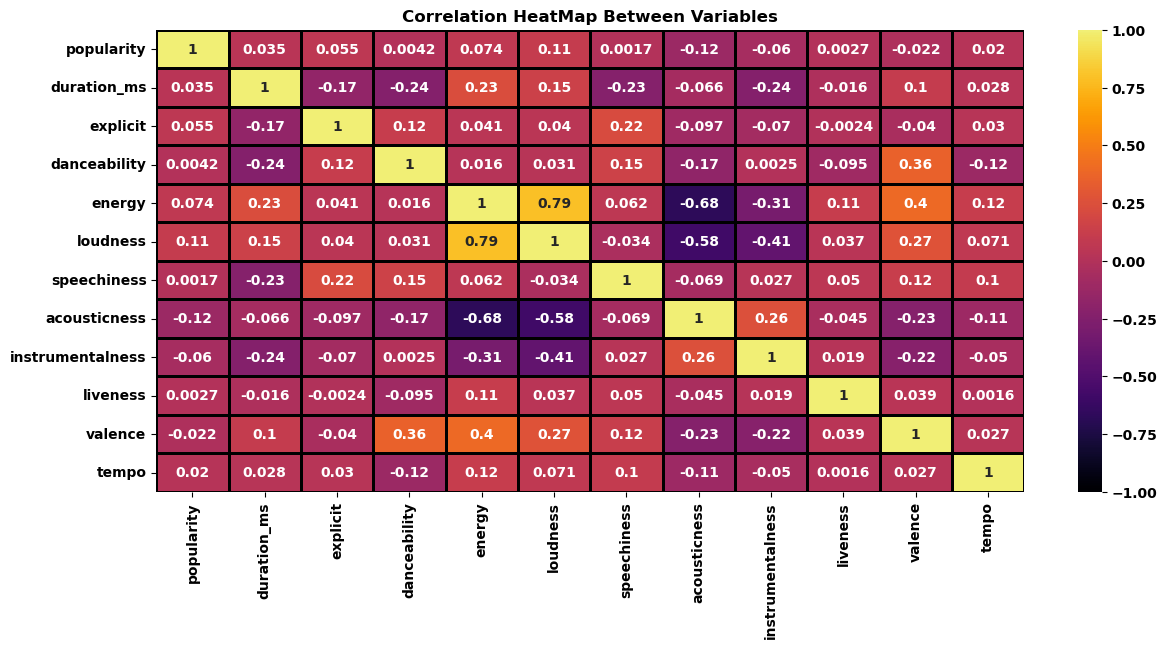

In [4]:
corr_pop = df_top_genres.drop(['key', 'mode', 'time_signature'], axis=1).corr(method='pearson', numeric_only=True)
#This code calculates the Pearson correlation coefficient between popularity and other musical features,
# excluding irrelevant columns.

plt.figure(figsize=(14,6))
heatmap = sns.heatmap(corr_pop,annot=True, vmin=-1.0, vmax=1.0, center=0.05, cmap='inferno', linewidths=1, linecolor='Black')
heatmap.set_title("Correlation HeatMap Between Variables")
heatmap.set_xticklabels(heatmap.get_xticklabels(),rotation=90)

Observaciones:

Se puede apreciar que los únicos con una mínima semejanza son k-pop y pop-film, donde este último está mas concentrado en popularidad cerca de 60.

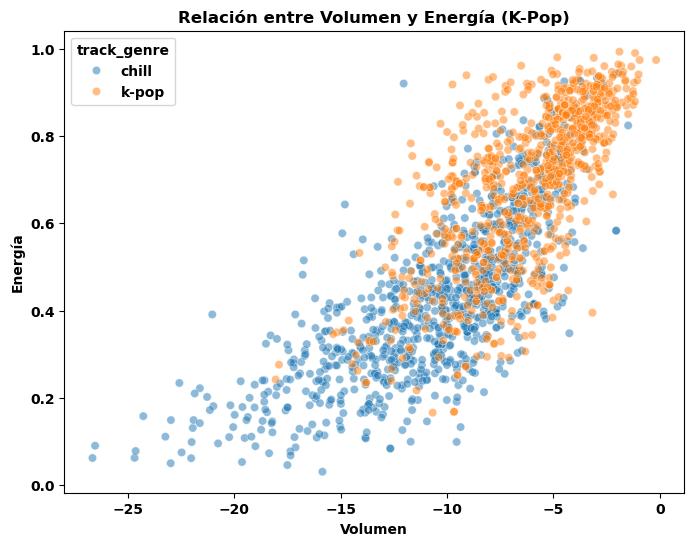

In [93]:
df_kpop  = df_top_genres[(df_top_genres['track_genre']=='k-pop') | (df_top_genres['track_genre']=='chill')] 
loudness = df_kpop['loudness']
energy = df_kpop['energy']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_kpop, x=df_top_genres['loudness'], y=df_top_genres['energy'],hue='track_genre', alpha=.5)
plt.title(f"Relación entre Volumen y Energía")
plt.xlabel("Volumen")
plt.ylabel("Energía")
plt.show()

Observación:

Se puede ver que hay una relación entre energía y volúmen.

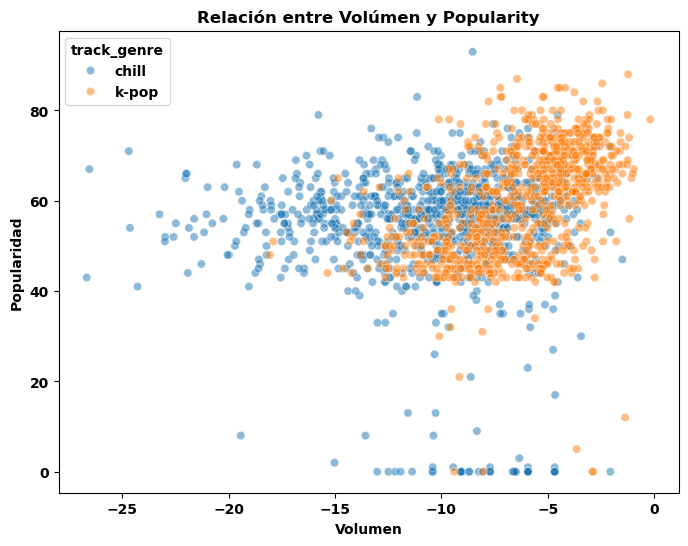

In [97]:
df_kpop  = df_top_genres[(df_top_genres['track_genre']=='k-pop') | (df_top_genres['track_genre']=='chill')] 
loudness = df_kpop['loudness']
popularity = df_kpop['popularity']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_kpop, x=df_top_genres['loudness'], y=df_top_genres['popularity'],hue='track_genre', alpha=.5)
plt.title(f"Relación entre Volúmen y Popularity")
plt.xlabel("Volumen")
plt.ylabel("Popularidad")
plt.show()

Observaciones:
No hay una relación clara entre volúmen y popularidad.

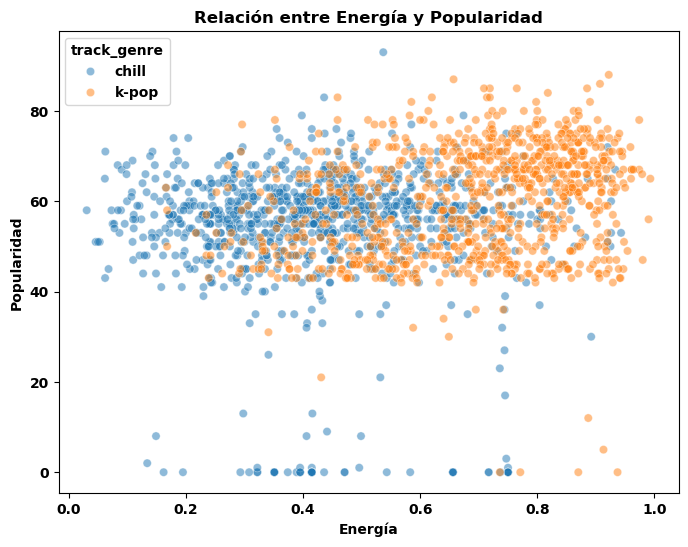

In [96]:
df_kpop  = df_top_genres[(df_top_genres['track_genre']=='k-pop') | (df_top_genres['track_genre']=='chill')] 
energy = df_kpop['energy']
popularity = df_kpop['popularity']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_kpop, x=df_top_genres['energy'], y=df_top_genres['popularity'],hue='track_genre', alpha=.5)
plt.title(f"Relación entre Energía y Popularidad")
plt.xlabel("Energía")
plt.ylabel("Popularidad")
plt.show()

Observaciones:
No hay una relación clara entre energía y popularidad.

In [ ]:
df_kpop  = df_top_genres[(df_top_genres['track_genre']=='k-pop') | (df_top_genres['track_genre']=='chill')] 
danceability = df_top_genres['danceability']
popularity = df_top_genres['popularity']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_top_genres, x=df_top_genres['danceability'], y=df_top_genres['popularity'], hue='track_genre', alpha=.5)
plt.title(f"Relación entre Bailabilidad y Popularidad (Top {top_n} Géneros)")
plt.xlabel("Bailabilidad")
plt.ylabel("Popularidad")
plt.show()